In [63]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
#from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import train_test_split
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

## Initialise the data

In [64]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

SEED = 42

random.seed(SEED)
tf.set_random_seed(SEED)

np.random.shuffle(train_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

Image: <PIL.Image.Image image mode=RGB size=64x64 at 0x7F3B0555F1D0>
Lable: [0.0, 1.0]


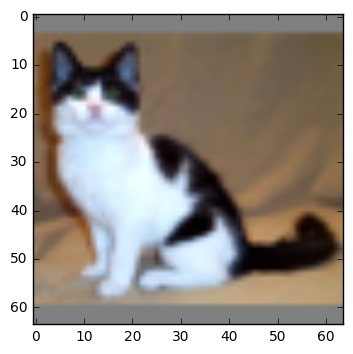

In [65]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print 'Image:', (processed_image)
print 'Lable:', (labels[random_index])
plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [66]:
print 'Image shape:', (np.array(processed_image).shape)

Image shape: (64, 64, 3)


In [67]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [68]:
from multiprocessing import Pool
import math

In [69]:
dataset_size = 25000
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print 'Training picture shape:', train[0].shape
print 'Numbers of training pictures and labels:', len(train), len(labels)

Training picture shape: (64, 64, 3)
Numbers of training pictures and labels: 25000 25000


In [188]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, step=1e-4, size=64, batch_size=100, weight_decay=0.5):
        self.weight_decay = weight_decay

        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        
        with tf.contrib.framework.arg_scope([layers.convolution2d],
            kernel_size=3, stride=1, rate=1, padding='SAME', activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)

            net = layers.convolution2d(self.X, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=32)

            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=64)
            
            net = layers.convolution2d(net, num_outputs=128)
            net = layers.convolution2d(net, num_outputs=128)
            net = layers.convolution2d(net, num_outputs=128)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=128)
            
            net = layers.convolution2d(net, num_outputs=256)
            net = layers.convolution2d(net, num_outputs=256)
            net = layers.convolution2d(net, num_outputs=256)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=256)
            
        with tf.contrib.framework.arg_scope([layers.fully_connected],
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):

            net = layers.flatten(net, [-1, 4 * 4 * 256])
            net = layers.fully_connected(net, num_outputs=64)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            
        net = layers.fully_connected(net, num_outputs=self.class_num)
        self.y = layers.softmax(net)

        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.AdamOptimizer(step).minimize(self.loss)

        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, iterations=2000, keep_prob=0.5, batch_test_size=512):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())

        batch_size = self.batch_size

        batch_start = 0
        batch_end = batch_start + batch_size

        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)

        batch_test_start = 0
        batch_test_end = batch_test_size
        epoch = 0

        for iteration in range(int(iterations)):
            _, loss, probs = self.sess.run(
                [self.optimizer, self.loss, self.y],
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )

            if iteration % 1000 == 0:
                train_acc = self.sess.run(
                    self.acc,
                    feed_dict={
                        self.X: X_train[batch_start:batch_end],
                        self.y_: y_train[batch_start:batch_end],
                        self.keep_prob: 1.0
                    }
                )
                
                val_acc, val_loss = self.__get_validation_scores(X_test, y_test, batch_test_size)

                print(
                    '{}({}):, tr_acc: {:.2%}, tr_loss: {:2.6}, val_acc: {:.2%}, val_loss: {:2.5}'.format(
                        iteration, epoch,  train_acc, loss, val_acc, val_loss)
                )

                if val_loss <= 0.1:
                    print('Validation loss is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                epoch += 1
                batch_start = 0
                batch_end = batch_start + batch_size

                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")
        
    def __get_validation_scores(self, X_test, y_test, batch_test_size):
        losses = []
        accs = []
        for chunk in range(0, len(X_test), batch_test_size):

            start_index = chunk
            end_index = chunk + batch_test_size

            batch_X = X_test[start_index:end_index]
            batch_y = y_test[start_index:end_index]

            batch_val_acc, batch_val_loss = self.sess.run(
                [self.acc, self.loss],
                feed_dict={
                    self.X: batch_X,
                    self.y_: batch_y,
                    self.keep_prob: 1.0}
            )
            
            losses.append(batch_val_loss)
            accs.append(batch_val_acc)
        
        return np.mean(accs), np.mean(losses)
        
    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = self.y

        predictions = []
        for i in range(0, len(test_x)):

            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]

            if len(batch) == 0:
                break
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})
            predict_batch = map(lambda x: x[0], predict_batch[0])
            predictions.extend(list(predict_batch))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d,%f'
        )

        print('saved: %s' % file_name)
        
    def predict(self, X):
        image = Preprocessor.get_image(X)
        processed_image = Preprocessor.get_processed_image(image, size=image_size)
        
        plt.imshow(processed_image)
        plt.show()
        
        X_processed = np.array(processed_image).reshape([-1, image_size, image_size, 3])
        predict = self.sess.run([self.y], feed_dict={self.X: X_processed, self.keep_prob: 1.0})
        
        prediction = predict[0][0]
        print prediction
        print 'I think it is a {creature}.'.format(
            creature='dog' if prediction[0] > prediction[1] else 'cat'
        )

# Initialise the model and train

In [189]:
class_num = 2
feature_number = image_size * image_size * 3

train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.1)  

In [ ]:
convnet = TFConvNet(
    feature_number,
    class_num,
    size=image_size,
    batch_size=16,
    step=5e-4, 
    weight_decay=350.0
)

In [ ]:
convnet.train(
    train_x,
    train_y,
    test_x,
    test_y,
    iterations=4e5,
    keep_prob=0.35,
    batch_test_size=32
)

Starting to train
0(0):, tr_acc: 62.50%, tr_loss: 0.751504, val_acc: 46.72%, val_loss: 0.73148
1000(0):, tr_acc: 50.00%, tr_loss: 0.630395, val_acc: 55.93%, val_loss: 0.68019
2000(1):, tr_acc: 62.50%, tr_loss: 0.750749, val_acc: 61.71%, val_loss: 0.64457
3000(2):, tr_acc: 62.50%, tr_loss: 0.75878, val_acc: 67.56%, val_loss: 0.58674
4000(2):, tr_acc: 75.00%, tr_loss: 0.502959, val_acc: 70.61%, val_loss: 0.56123
5000(3):, tr_acc: 50.00%, tr_loss: 0.835718, val_acc: 72.43%, val_loss: 0.51489
6000(4):, tr_acc: 81.25%, tr_loss: 0.455689, val_acc: 77.73%, val_loss: 0.47775
7000(4):, tr_acc: 75.00%, tr_loss: 0.558539, val_acc: 80.02%, val_loss: 0.43691
8000(5):, tr_acc: 68.75%, tr_loss: 0.768615, val_acc: 82.44%, val_loss: 0.39549
9000(6):, tr_acc: 75.00%, tr_loss: 0.469724, val_acc: 83.70%, val_loss: 0.36937
10000(7):, tr_acc: 93.75%, tr_loss: 0.238628, val_acc: 84.02%, val_loss: 0.35843
11000(7):, tr_acc: 87.50%, tr_loss: 0.309298, val_acc: 84.57%, val_loss: 0.35116
12000(8):, tr_acc: 81.25

# Model generalization exploration

983


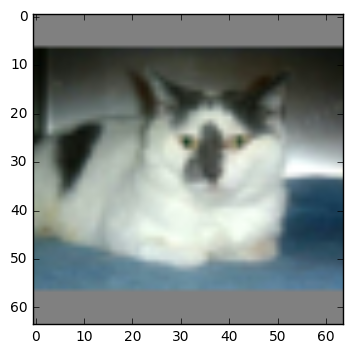

[ 0.62681323  0.37318674]
I think it is a dog.


In [136]:
for i in range(1):
    random_index = np.random.randint(0, len(train_all))
    print random_index
    image_path = train_all[random_index]
    convnet.predict(image_path)

# Process test data

In [137]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [138]:
print 'Test image shape:', test[0].shape

Test image shape: (64, 64, 3)


In [139]:
print test_all[:3]

['../dataset/test/1.jpg', '../dataset/test/2.jpg', '../dataset/test/3.jpg']


# Generate submission

In [140]:
convnet.generate_submission(test)

Preparing to generate submission.csv
(12500, 12500)
saved: submission.csv
